### Analysis  of inference time

In [1]:
# load important modules

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import math

#### Data preprocessing

In [2]:
# Load the datasets into a pandas dataframe.

# WNLI
wnli_uncased = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/inference time/WNLI_uncased.csv", 
                   delimiter=',', decimal=',', index_col = 0)

# RTE
rte_uncased = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/inference time/RTE_uncased.csv", 
                   delimiter=',', decimal=',', index_col = 0)
rte_cased = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/inference time/RTE_cased.csv", 
                   delimiter=',', decimal=',', index_col = 0)

# MRPC
mrpc_all = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/inference time/MRPC_all.csv", 
                   delimiter=',', decimal=',', index_col = 0)

# CoLA
cola_all = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/inference time/CoLa_all.csv", 
                   delimiter=',', decimal=',', index_col = 0)

# SST-B
stsb_all = pd.read_csv("C:/Users/annko/Documents/Masterthesis/wandb/inference time/STS-B_all.csv", 
                   delimiter=',', decimal=',', index_col = 0)

data = pd.concat([wnli_uncased, rte_uncased, rte_cased, mrpc_all, cola_all, stsb_all])

In [3]:
# only regard important variables
data2 = data[['State', 'task_name', 'model_name_or_path', 'learning_rate', 'per_device_eval_batch_size', 'max_seq_length', 
              'eval_steps', 'eval_acc', 'eval_loss', 'eval_corr', 'eval_f1', 'eval_mcc', 'eval_pearson', 'eval_spearmanr',
              'inference_time_list', 'weight_decay', 'loss', 'per_device_train_batch_size']]
data2.index = range(0,len(data2))
print(data2.shape)
data2.head()

(297, 18)


,State,task_name,model_name_or_path,learning_rate,per_device_eval_batch_size,max_seq_length,eval_steps,eval_acc,eval_loss,eval_corr,eval_f1,eval_mcc,eval_pearson,eval_spearmanr,inference_time_list,weight_decay,loss,per_device_train_batch_size
0,finished,WNLI,xlnet-base-cased,0.00005,32,512,1000,0.5633802816901409,0.6876857082049052,NaN,NaN,NaN,NaN,NaN,"[27.37428379058838,29.795268535614017,8.499287...",0.01,NaN,32
1,finished,WNLI,xlnet-base-cased,0.00005,16,512,1000,0.5633802816901409,0.6922690868377686,NaN,NaN,NaN,NaN,NaN,"[15.803596496582031,16.847050189971924,18.1047...",0.01,NaN,32
2,finished,WNLI,xlnet-base-cased,0.00005,8,512,1000,0.5633802816901409,0.6953247057067024,NaN,NaN,NaN,NaN,NaN,"[8.346511363983154,9.028968334197998,9.0649039...",0.01,NaN,32
3,finished,WNLI,albert-base-v1,0.00005,32,512,1000,0.5352112676056338,0.7054780324300131,NaN,NaN,NaN,NaN,NaN,"[7.800238132476807,7.557276248931885,1.7162435...",0.01,NaN,32
4,finished,WNLI,albert-base-v1,0.00005,16,512,1000,0.5352112676056338,0.7036268472671509,NaN,NaN,NaN,NaN,NaN,"[3.5223352909088135,3.8956010341644287,3.68044...",0.01,NaN,32


In [4]:
# add column with number of observations
data2.loc[(data2.task_name == 'WNLI'), 'num_examples'] = 71
data2.loc[(data2.task_name == 'RTE'), 'num_examples'] = 277
data2.loc[(data2.task_name == 'MRPC'), 'num_examples'] = 408
data2.loc[(data2.task_name == 'CoLA'), 'num_examples'] = 1042
data2.loc[(data2.task_name == 'STS-B'), 'num_examples'] = 1500

C:\Users\annko\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\annko\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
# there are some runs in the dataset that failed/crashed --> only include finished runs
data3 = data2.loc[data2.State == 'finished']

data3.shape[0] # number of examples

267

In [6]:
# Describe respective variables 
data3.describe()

,per_device_eval_batch_size,max_seq_length,eval_steps,per_device_train_batch_size,num_examples
count,267.000000,267.000000,267.0,267.0,267.000000
mean,18.666667,303.460674,1000.0,32.0,653.932584
std,9.996491,161.278193,0.0,0.0,509.411199
min,8.000000,128.000000,1000.0,32.0,71.000000
25%,8.000000,128.000000,1000.0,32.0,277.000000
50%,16.000000,256.000000,1000.0,32.0,408.000000
75%,32.000000,512.000000,1000.0,32.0,1042.000000
max,32.000000,512.000000,1000.0,32.0,1500.000000


In [7]:
# Regard info of several features (need to change the type of some variables)
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 0 to 296
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   State                        267 non-null    object 
 1   task_name                    267 non-null    object 
 2   model_name_or_path           267 non-null    object 
 3   learning_rate                267 non-null    object 
 4   per_device_eval_batch_size   267 non-null    int64  
 5   max_seq_length               267 non-null    int64  
 6   eval_steps                   267 non-null    int64  
 7   eval_acc                     159 non-null    object 
 8   eval_loss                    267 non-null    object 
 9   eval_corr                    45 non-null     object 
 10  eval_f1                      51 non-null     object 
 11  eval_mcc                     63 non-null     object 
 12  eval_pearson                 45 non-null     object 
 13  eval_spearmanr      

In [8]:
# change the format of the inferece list in order to ba able to work with it
def timelist_transform(data = data3.inference_time_list):
    
    # save transformed results in defaultdict
    time_dict = defaultdict(list)
    counter = 0
    
    for row in data:
        time_list = []
        for i in row.strip('][').split(','):
            time_list.append(float(i))
        time_dict[data3.index[counter]] = time_list
        counter += 1
        
    return time_dict

In [9]:
# add transformed lists to dataframe
inference_dict = timelist_transform(data3.inference_time_list)
data3.loc[:,'inference_time_list'] = data3.index.map(inference_dict)

C:\Users\annko\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# check if type conversion succeeded
print(type(data3.inference_time_list[9])) # list
print(type(data3.inference_time_list[9][1])) #float
data3.inference_time_list.sample(2)

<class 'list'>
<class 'float'>


67    [0.7600882053375244, 0.7472898960113525, 0.633...
94    [4.047609329223633, 3.944408178329468, 3.92008...
Name: inference_time_list, dtype: object

In [11]:
# add number of measurements for the inference time
data3['inference_time_number'] = data3.loc[:,'inference_time_list'].apply(lambda x: len(x))

<ipython-input-11-78df7a6b1ef9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['inference_time_number'] = data3.loc[:,'inference_time_list'].apply(lambda x: len(x))


In [12]:
# change variable types
data3.loc[:,'model_name_or_path'] = data3.loc[:,'model_name_or_path'].astype('category')
data3.loc[:,'task_name'] = data3.loc[:,'task_name'].astype('category')
data3.loc[:,'learning_rate'] = data3.loc[:,'learning_rate'].astype('float64')
data3.loc[:,'eval_acc'] = data3.loc[:,'eval_acc'].astype('float64')
data3.loc[:,'eval_loss'] = data3.loc[:,'eval_loss'].astype('float64')
data3.loc[:,'num_examples'] = data3.loc[:,'num_examples'].astype('int64')

In [13]:
# calculate minimal inference_time

print(data3.loc[:,'inference_time_list'].head())
# delete last element of inference time list because there are less elements -> smaller batch size
print(data3.loc[:,'inference_time_list'].apply(lambda x: x.pop()))

data3['inference_time'] = data3.loc[:,'inference_time_list'].apply(lambda x: min(x))

0    [27.37428379058838, 29.795268535614017, 8.4992...
1    [15.803596496582031, 16.847050189971924, 18.10...
2    [8.346511363983154, 9.028968334197998, 9.06490...
3    [7.800238132476807, 7.557276248931885, 1.71624...
4    [3.5223352909088135, 3.8956010341644287, 3.680...
Name: inference_time_list, dtype: object
0      8.499288
1      8.176691
2      8.039012
3      1.716244
4      0.937934
         ...   
289    0.197364
290    0.091762
294    0.803784
295    0.423499
296    0.145182
Name: inference_time_list, Length: 267, dtype: float64


<ipython-input-13-8f563ecf2ee3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['inference_time'] = data3.loc[:,'inference_time_list'].apply(lambda x: min(x))


In [14]:
# learning rate value of MRPC was not recognized properly -> added manually
data3.loc[(data3.task_name == 'MRPC'), 'learning_rate'] = 3e-5

#### Descriptive analysis

In [15]:
# print maximal inference time
print('Maximal inference time')
print(' ')
print(data3.loc[data3.inference_time.idxmax(axis=0),:])

# minimal inference time
print(' ')
print('Minimal inference time')
print(' ')
print(data3.loc[data3.inference_time.idxmin(axis=0),:])

Maximal inference time
 
State                                                         finished
task_name                                                         WNLI
model_name_or_path                                    xlnet-base-cased
learning_rate                                                    5e-05
per_device_eval_batch_size                                          32
max_seq_length                                                     512
eval_steps                                                        1000
eval_acc                                                       0.56338
eval_loss                                                     0.687686
eval_corr                                                          NaN
eval_f1                                                            NaN
eval_mcc                                                           NaN
eval_pearson                                                       NaN
eval_spearmanr                                      

In [16]:
data3.head()

,State,task_name,model_name_or_path,learning_rate,per_device_eval_batch_size,max_seq_length,eval_steps,eval_acc,eval_loss,eval_corr,...,eval_mcc,eval_pearson,eval_spearmanr,inference_time_list,weight_decay,loss,per_device_train_batch_size,num_examples,inference_time_number,inference_time
0,finished,WNLI,xlnet-base-cased,0.00005,32,512,1000,0.563380,0.687686,NaN,...,NaN,NaN,NaN,"[27.37428379058838, 29.795268535614017]",0.01,NaN,32,71,3,27.374284
1,finished,WNLI,xlnet-base-cased,0.00005,16,512,1000,0.563380,0.692269,NaN,...,NaN,NaN,NaN,"[15.803596496582031, 16.847050189971924, 18.10...",0.01,NaN,32,71,5,15.803596
2,finished,WNLI,xlnet-base-cased,0.00005,8,512,1000,0.563380,0.695325,NaN,...,NaN,NaN,NaN,"[8.346511363983154, 9.028968334197998, 9.06490...",0.01,NaN,32,71,9,8.346511
3,finished,WNLI,albert-base-v1,0.00005,32,512,1000,0.535211,0.705478,NaN,...,NaN,NaN,NaN,"[7.800238132476807, 7.557276248931885]",0.01,NaN,32,71,3,7.557276
4,finished,WNLI,albert-base-v1,0.00005,16,512,1000,0.535211,0.703627,NaN,...,NaN,NaN,NaN,"[3.5223352909088135, 3.8956010341644287, 3.680...",0.01,NaN,32,71,5,3.522335


In [17]:
# describe inference time
data3.inference_time.describe()

count    267.000000
mean       1.974390
std        3.734141
min        0.091526
25%        0.319447
50%        0.628010
75%        1.899108
max       27.374284
Name: inference_time, dtype: float64

In [18]:
# calculate number of batces (should be equal to number of inference time measurements)
data3['number_batches'] = data3.num_examples/data3.per_device_eval_batch_size

<ipython-input-18-db3895173172>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['number_batches'] = data3.num_examples/data3.per_device_eval_batch_size


In [19]:
# display number of inference time measurements
# (number of examples)/(batch size) should equal number of batches and also number of infernce time measurements 
data3.groupby(['per_device_eval_batch_size', 'num_examples', 'number_batches']).inference_time_number.describe()
# for example: num_examples = 71; batch size = 8 -> 71/8 = 8.875, which equals approx. 9
# Attention! if a number has a decimal point, it is the number of batches (and inference time measurements) 
    # always equals the rounded up number

count   mean  std  \
per_device_eval_batch_size num_examples number_batches                      
8                          71           8.87500          15.0    9.0  0.0   
                           277          34.62500         21.0   35.0  0.0   
                           408          51.00000         17.0   51.0  0.0   
                           1042         130.25000        21.0  131.0  0.0   
                           1500         187.50000        15.0  188.0  0.0   
16                         71           4.43750          15.0    5.0  0.0   
                           277          17.31250         21.0   18.0  0.0   
                           408          25.50000         17.0   26.0  0.0   
                           1042         65.12500         21.0   66.0  0.0   
                           1500         93.75000         15.0   94.0  0.0   
32                         71           2.21875          15.0    3.0  0.0   
                           277          8.65625          21.0    9.0  0.0   
                           408          12.75000         17.0   13.0  0.0   
                           1042         32.56250         21.0   33.0  0.0   
                           1500         46.87500         15.0   47.0  0.0   

                                                          min    25%    50%  \
per_device_eval_batch_size num_examples number_batches                        
8                          71           8.87500           9.0    9.0    9.0   
                           277          34.62500         35.0   35.0   35.0   
                           408          51.00000         51.0   51.0   51.0   
                           1042         130.25000       131.0  131.0  131.0   
                           1500         187.50000       188.0  188.0  188.0   
16                         71           4.43750           5.0    5.0    5.0   
                           277          17.31250         18.0   18.0   18.0   
                           408          25.50000         26.0   26.0   26.0   
                           1042         65.12500         66.0   66.0   66.0   
                           1500         93.75000         94.0   94.0   94.0   
32                         71           2.21875           3.0    3.0    3.0   
                           277          8.65625           9.0    9.0    9.0   
                           408          12.75000         13.0   13.0   13.0   
                           1042         32.56250         33.0   33.0   33.0   
                           1500         46.87500         47.0   47.0   47.0   

                                                          75%    max  
per_device_eval_batch_size num_examples number_batches                
8                          71           8.87500           9.0    9.0  
                           277          34.62500         35.0   35.0  
                           408          51.00000         51.0   51.0  
                           1042         130.25000       131.0  131.0  
                           1500         187.50000       188.0  188.0  
16                         71           4.43750           5.0    5.0  
                           277          17.31250         18.0   18.0  
                           408          25.50000         26.0   26.0  
                           1042         65.12500         66.0   66.0  
                           1500         93.75000         94.0   94.0  
32                         71           2.21875           3.0    3.0  
                           277          8.65625           9.0    9.0  
                           408          12.75000         13.0   13.0  
                           1042         32.56250         33.0   33.0  
                           1500         46.87500         47.0   47.0

In [20]:
## regard statistical key values, such as median, etc of inference time
median = data3.inference_time.median()
upper_quartile = data3.inference_time.quantile(0.75)
lower_quartile = data3.inference_time.quantile(0.25)
maximum = data3.inference_time.max()

iqr = upper_quartile - lower_quartile
upper_whisker = data3.inference_time[data3.inference_time<=upper_quartile+1.5*iqr].max()
lower_whisker = data3.inference_time[data3.inference_time>=lower_quartile-1.5*iqr].min()

In [21]:
# Detection of outliers (with values higher than the upper whisker)

data3.sort_values(by=['inference_time'], ascending=False).loc[(data3.inference_time > upper_whisker), 
                ['task_name', 'model_name_or_path', 'max_seq_length', 'per_device_train_batch_size',
                'inference_time', 'eval_acc']]

,task_name,model_name_or_path,max_seq_length,per_device_train_batch_size,inference_time,eval_acc
0,WNLI,xlnet-base-cased,512,32,27.374284,0.563380
45,RTE,xlnet-base-cased,512,32,26.955771,0.570397
108,MRPC,xlnet-base-cased,512,32,19.563092,0.806373
234,STS-B,xlnet-base-cased,512,32,19.205167,NaN
171,CoLA,xlnet-base-cased,512,32,18.842612,NaN
1,WNLI,xlnet-base-cased,512,32,15.803596,0.563380
46,RTE,xlnet-base-cased,512,32,15.446428,0.570397
172,CoLA,xlnet-base-cased,512,32,11.721651,NaN
235,STS-B,xlnet-base-cased,512,32,11.423589,NaN
109,MRPC,xlnet-base-cased,512,32,11.165368,0.806373


In [22]:
# Are there outliers with values than the lower bound? -> No

print(data3.sort_values(by=['inference_time'], ascending=False).loc[(data3.inference_time < lower_whisker), 
                ['task_name', 'model_name_or_path', 'max_seq_length', 'per_device_train_batch_size',
                'inference_time', 'eval_acc']])

Empty DataFrame
Columns: [task_name, model_name_or_path, max_seq_length, per_device_train_batch_size, inference_time, eval_acc]
Index: []


In [23]:
# Ten highest inference times

data3.sort_values(by=['inference_time'], ascending=False).loc[:, ['task_name', 'model_name_or_path', 'max_seq_length',
                                                                  'per_device_eval_batch_size', 'inference_time', 
                                                                  'eval_acc', 'eval_spearmanr', 'eval_mcc']].head(10)

,task_name,model_name_or_path,max_seq_length,per_device_eval_batch_size,inference_time,eval_acc,eval_spearmanr,eval_mcc
0,WNLI,xlnet-base-cased,512,32,27.374284,0.563380,NaN,NaN
45,RTE,xlnet-base-cased,512,32,26.955771,0.570397,NaN,NaN
108,MRPC,xlnet-base-cased,512,32,19.563092,0.806373,NaN,NaN
234,STS-B,xlnet-base-cased,512,32,19.205167,NaN,0.8342460732012076,NaN
171,CoLA,xlnet-base-cased,512,32,18.842612,NaN,NaN,0
1,WNLI,xlnet-base-cased,512,16,15.803596,0.563380,NaN,NaN
46,RTE,xlnet-base-cased,512,16,15.446428,0.570397,NaN,NaN
172,CoLA,xlnet-base-cased,512,16,11.721651,NaN,NaN,0
235,STS-B,xlnet-base-cased,512,16,11.423589,NaN,0.8342460732012076,NaN
109,MRPC,xlnet-base-cased,512,16,11.165368,0.806373,NaN,NaN


In [24]:
# Ten lowest inference times

data3.sort_values(by=['inference_time'], ascending=True).loc[:, ['task_name', 'model_name_or_path', 'max_seq_length',
                                                                  'per_device_eval_batch_size', 'inference_time', 
                                                                  'eval_acc', 'eval_spearmanr', 'eval_mcc']].head(10)

,task_name,model_name_or_path,max_seq_length,per_device_eval_batch_size,inference_time,eval_acc,eval_spearmanr,eval_mcc
224,CoLA,distilbert-base-cased,128,8,0.091526,NaN,NaN,0.2260831198515493
227,CoLA,distilbert-base-uncased,128,8,0.092450,NaN,NaN,0
41,WNLI,distilbert-base-uncased,128,8,0.092698,0.380282,NaN,NaN
290,STS-B,distilbert-base-uncased,128,8,0.093888,NaN,0.8400719277503214,NaN
104,RTE,distilbert-base-cased,128,8,0.095470,0.537906,NaN,NaN
164,MRPC,distilbert-base-uncased,128,8,0.095592,0.713235,NaN,NaN
86,RTE,distilbert-base-uncased,128,8,0.097367,0.570397,NaN,NaN
226,CoLA,distilbert-base-uncased,128,16,0.144093,NaN,NaN,0
289,STS-B,distilbert-base-uncased,128,16,0.146439,NaN,0.8400719277503214,NaN
223,CoLA,distilbert-base-cased,128,16,0.147065,NaN,NaN,0.2260831198515493


In [25]:
print("Minimum: ", data3.inference_time.min())
print("Lower whisker: ", lower_whisker)
print("Median: ", median)
print("Upper whisker: ", upper_whisker)
print("Maximum: ", maximum)

Minimum:  0.09152603149414062
Lower whisker:  0.09152603149414062
Median:  0.6280100345611572
Upper whisker:  3.832861185073853
Maximum:  27.37428379058838


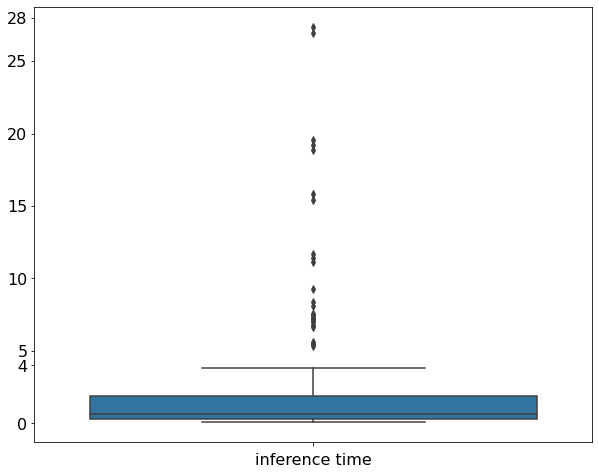

In [26]:
# Boxplot of inference time

plt.figure(figsize = (10, 8))
ax = sns.boxplot(y = 'inference_time', data = data3)
ax.set_yticks([0, math.ceil(upper_whisker), 5, 10, 15, 20, 25, math.ceil(maximum)])
plt.xlabel('inference time', fontsize = 16)
plt.ylabel('')
#plt.title('Boxplot of inference time', fontsize = 18)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('inference_time_boxplot.png')

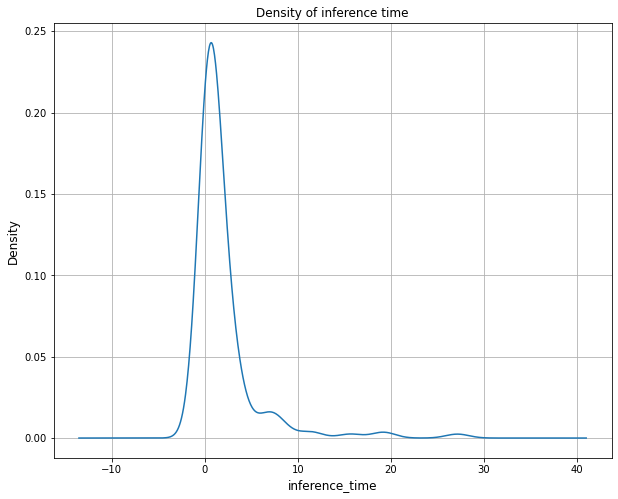

In [27]:
# Plot density of inference time

plt.figure(figsize = (10, 8))
data3.inference_time.plot(kind = 'kde', grid = True,linestyle = '-')
plt.xlabel('inference_time', fontsize = 12)
plt.ylabel('Density', fontsize = 12)
plt.title('Density of inference time', fontsize = 12)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=12)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=12)
plt.show()

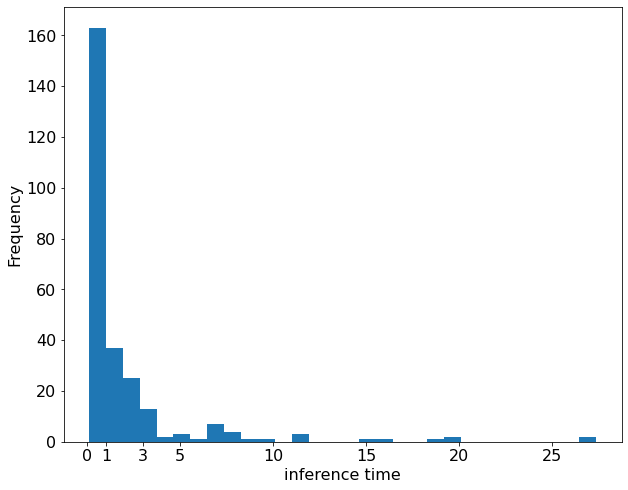

In [28]:
# Histogram inference time

plt.figure(figsize = (10, 8))
ax = data3.inference_time.plot(kind = 'hist', bins = 30)
ax.set_xticks([0, 1, 3, 5, 10, 15, 20, 25])
plt.xlabel('inference time', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
#plt.title('Frequency of inference time', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('inference_time_hist.png')

In [29]:
counts, bin_edges = np.histogram(data3.inference_time, bins=20)
print(counts, bin_edges)

[193  32  15   3   3   9   2   0   3   0   0   2   0   1   2   0   0   0
   0   2] [ 0.09152603  1.45566392  2.81980181  4.1839397   5.54807758  6.91221547
  8.27635336  9.64049125 11.00462914 12.36876702 13.73290491 15.0970428
 16.46118069 17.82531857 19.18945646 20.55359435 21.91773224 23.28187013
 24.64600801 26.0101459  27.37428379]


#### Plot correlations

In [30]:
# Correlation matrix
data_sub = data3[["per_device_eval_batch_size", "max_seq_length", "num_examples", "inference_time"]] 
                    # "eval_acc", "eval_loss", "learning_rate",
data_sub.corr()

,per_device_eval_batch_size,max_seq_length,num_examples,inference_time
per_device_eval_batch_size,1.000000e+00,3.605324e-17,9.400058e-18,0.276153
max_seq_length,3.605324e-17,1.000000e+00,-1.440457e-02,0.418042
num_examples,9.400058e-18,-1.440457e-02,1.000000e+00,-0.079396
inference_time,2.761534e-01,4.180424e-01,-7.939631e-02,1.000000


In [31]:
data_sub.columns

Index(['per_device_eval_batch_size', 'max_seq_length', 'num_examples',
       'inference_time'],
      dtype='object')

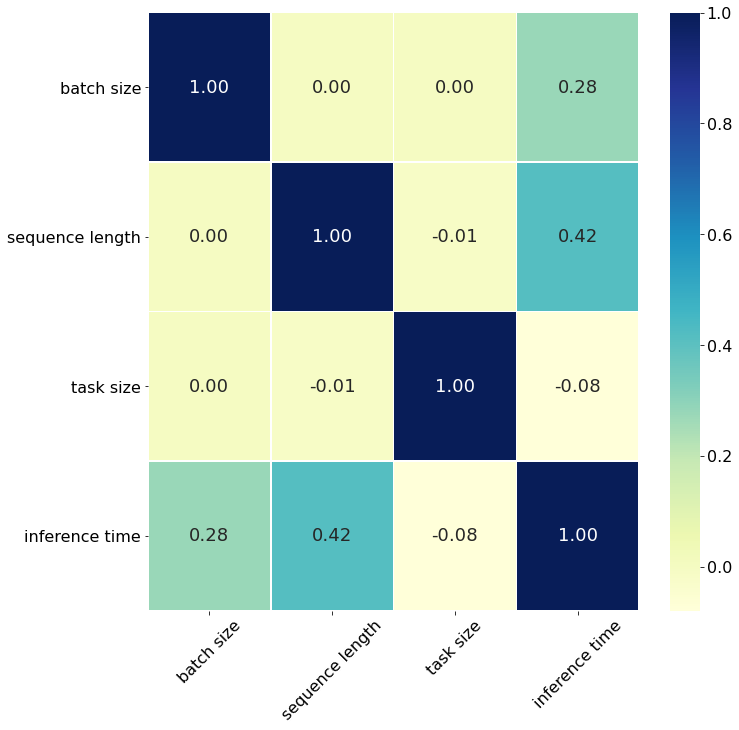

In [32]:
# correlation matrix plot
plt.rcParams['font.size'] = 16
plt.figure(figsize=(11,11))
ht = sns.heatmap(data_sub.corr(), annot=True, linewidths=.5, fmt= '.2f', cmap="YlGnBu", annot_kws={'size':18})
plt.xticks(np.arange(len(data_sub.columns))+0.5, labels = ['batch size', 'sequence length', 'task size', 'inference time' ], fontsize = 16, 
           rotation=45)
plt.yticks(np.arange(len(data_sub.columns))+0.5, labels = ['batch size', 'sequence length', 'task size', 'inference time' ], fontsize = 16)
#plt.title('Correlation plot', fontsize = 18)
plt.show()
ht.figure.savefig('inference_correlation_plot.png', bbox_inches='tight')

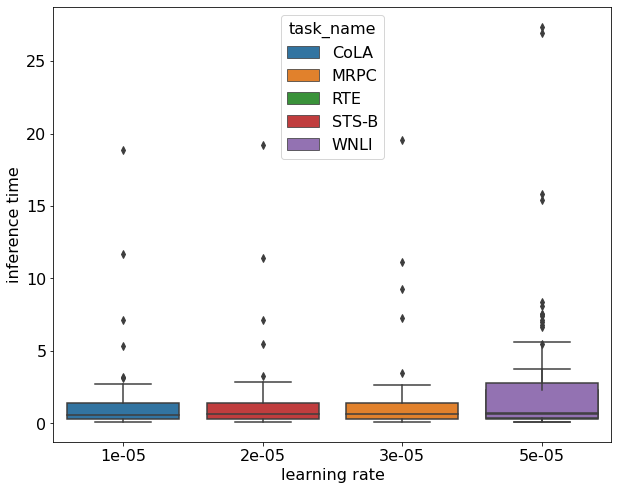

In [33]:
# Boxplots for inference time, gouped by learning rate

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'learning_rate', y = 'inference_time', hue = 'task_name', data = data3, dodge = False)
plt.ylabel('inference time', fontsize = 16)
plt.xlabel('learning rate', fontsize = 16)
#plt.title('Boxplot of inference time by learning rate', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
#ax.figure.savefig('inference_time_hist.png')

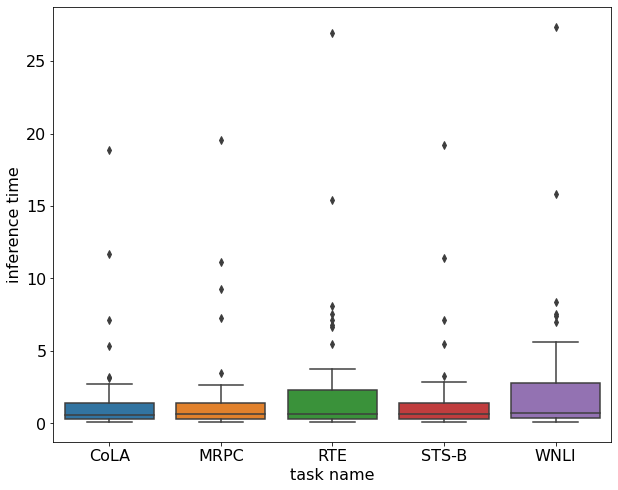

In [34]:
# Boxplots for inference time, gouped by task_name

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'task_name', y = 'inference_time', data = data3)
plt.ylabel('inference time', fontsize = 16)
plt.xlabel('task name', fontsize = 16)
#plt.title('Boxplot of inference time by task name', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('inference_time_task.png')

In [35]:
data3.groupby('task_name').inference_time.describe()

,count,mean,std,min,25%,50%,75%,max
task_name,,,,,,,,
CoLA,63.0,1.490838,2.882897,0.091526,0.310897,0.563840,1.373041,18.842612
MRPC,51.0,1.790568,3.334485,0.095592,0.324822,0.648757,1.434170,19.563092
RTE,63.0,2.217525,4.146957,0.095470,0.326230,0.618110,2.272805,26.955771
STS-B,45.0,1.809717,3.366402,0.093888,0.310691,0.653273,1.388232,19.205167
WNLI,45.0,2.683981,4.835715,0.092698,0.374143,0.690526,2.769030,27.374284


In [36]:
# For a fair comparison the models albert-base-v1, distilbert-base-cased and bert-base-cased are not regarded in the following 
data3[(data3.model_name_or_path != 'albert-base-v1') & (data3.model_name_or_path != 'distilbert-base-cased') 
      & (data3.model_name_or_path != 'bert-base-cased')].groupby('task_name').inference_time.describe()

,count,mean,std,min,25%,50%,75%,max
task_name,,,,,,,,
CoLA,36.0,2.028410,3.691562,0.092450,0.335937,0.585906,1.992505,18.842612
MRPC,36.0,2.133130,3.903808,0.095592,0.326205,0.647629,2.021783,19.563092
RTE,36.0,2.855300,5.177061,0.097367,0.328523,0.725757,3.155621,26.955771
STS-B,36.0,2.040408,3.718444,0.093888,0.308234,0.674409,2.087234,19.205167
WNLI,36.0,2.899120,5.277764,0.092698,0.367639,0.714683,2.936558,27.374284


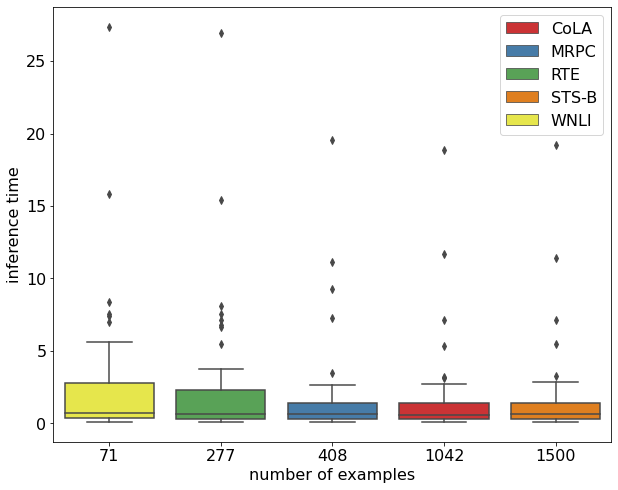

In [37]:
# Boxplots for inference time, gouped by number pf examples

plt.figure(figsize = (10, 8))
my_pal = {"WNLI": "#ffff33", "STS-B": "#ff7f00", "RTE": "#4daf4a", "MRPC": "#377eb8", "CoLA": "#e41a1c"}
ax = sns.boxplot(x = 'num_examples', y = 'inference_time', data = data3, hue = 'task_name', dodge=False, 
                 palette = my_pal)
plt.legend(loc='upper right')
plt.ylabel('inference time', fontsize = 16)
plt.xlabel('number of examples', fontsize = 16)
#plt.title('Boxplot of inference time by number of examples', fontsize = 18) 
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('inference_time_number.png')

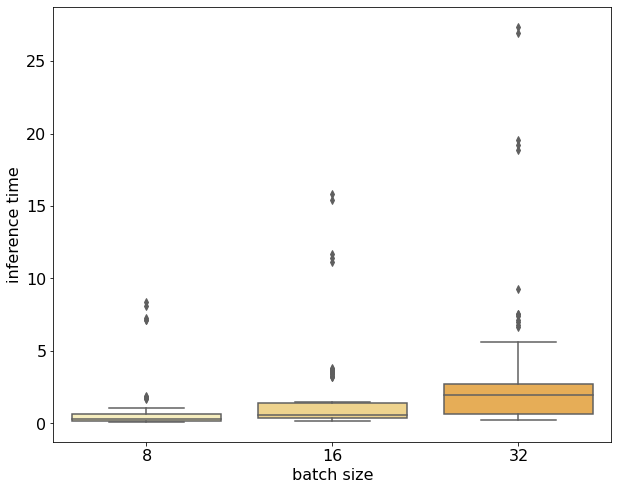

In [38]:
# Boxplots for inference time, grouped by batch size

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'per_device_eval_batch_size', y = 'inference_time', data = data3, palette = sns.color_palette('YlOrBr'))
plt.ylabel('inference time', fontsize = 16)
plt.xlabel('batch size', fontsize = 16)
#plt.title('Boxplot of inference time by batch size', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('inference_time_batch_size.png')

In [39]:
data3.groupby('per_device_eval_batch_size').inference_time.describe()

,count,mean,std,min,25%,50%,75%,max
per_device_eval_batch_size,,,,,,,,
8,89.0,0.854028,1.706136,0.091526,0.186230,0.319323,0.67533,8.346511
16,89.0,1.729359,3.022269,0.144093,0.343626,0.608390,1.37256,15.803596
32,89.0,3.339784,5.185330,0.249477,0.614942,1.942168,2.69934,27.374284


In [40]:
# for a fair comparison, exclude SST-2 and MRPC (because albert crashed for seq len = 512 and MRPC failed
# for bert-cased und distilbert-cased with 128 and 256); same trend as before
data3[(data3.task_name != 'MRPC') & 
      (data3.task_name != 'SST-2')].groupby('per_device_eval_batch_size').inference_time.describe()

,count,mean,std,min,25%,50%,75%,max
per_device_eval_batch_size,,,,,,,,
8,72.0,0.869652,1.724430,0.091526,0.185808,0.316435,0.678308,8.346511
16,72.0,1.787496,3.124161,0.144093,0.350619,0.595524,1.374133,15.803596
32,72.0,3.396231,5.322460,0.249477,0.581690,1.770520,2.794105,27.374284


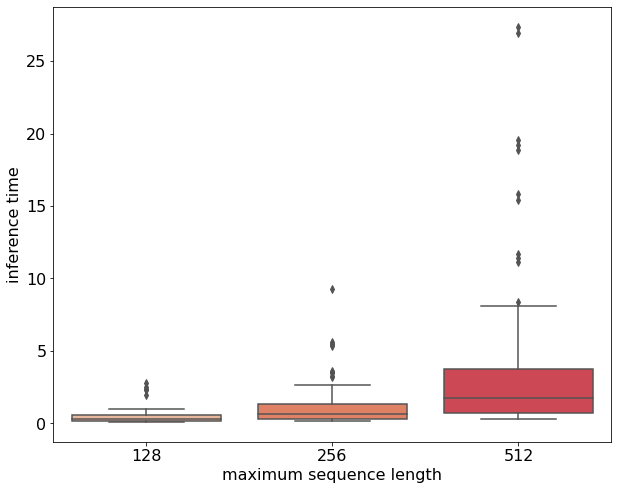

In [41]:
# Boxplots for inference time, gouped by max sequence length

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'max_seq_length', y = 'inference_time', data = data3, palette = sns.color_palette('rocket_r'))
plt.xlabel('maximum sequence length', fontsize = 16)
plt.ylabel('inference time', fontsize = 16)
#plt.title('Boxplot of inference time by maximum sequence length', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('inference_time_seq_length.png')

In [42]:
data3.groupby('max_seq_length').inference_time.describe()

,count,mean,std,min,25%,50%,75%,max
max_seq_length,,,,,,,,
128,87.0,0.457988,0.517178,0.091526,0.186052,0.321509,0.551895,2.769030
256,87.0,1.242161,1.552812,0.150376,0.320631,0.615759,1.306774,9.251770
512,93.0,4.077948,5.536896,0.286959,0.715284,1.750884,3.739821,27.374284


In [43]:
data3[(data3.task_name != 'MRPC')].groupby('max_seq_length').inference_time.describe()

,count,mean,std,min,25%,50%,75%,max
max_seq_length,,,,,,,,
128,72.0,0.457633,0.531975,0.091526,0.185808,0.316467,0.551778,2.769030
256,72.0,1.174064,1.348102,0.150376,0.318750,0.601432,1.299718,5.581477
512,72.0,4.421681,5.764488,0.286959,1.254267,2.160660,6.682378,27.374284


C:\Users\annko\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\annko\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


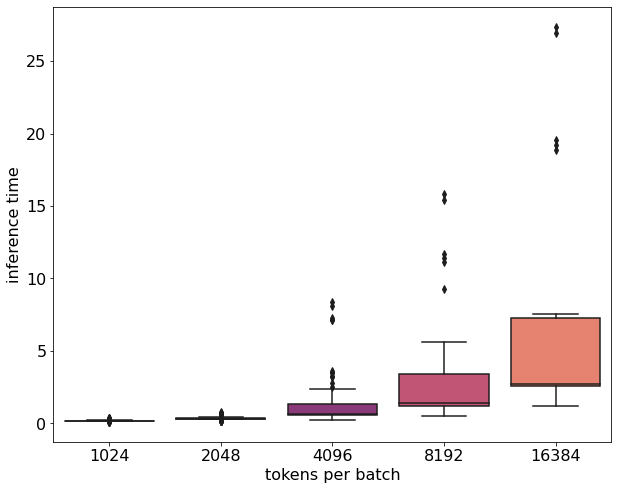

In [44]:
# Boxplots for inference time, gouped by tokens per batch

# add tokens per batch to dataset
data3.loc[:,'tokens_per_batch'] = data3.apply(lambda row: (row['per_device_eval_batch_size']*row['max_seq_length']), axis=1)

plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = 'tokens_per_batch', y = 'inference_time', data = data3, palette = sns.color_palette('magma'))
plt.ylabel('inference time', fontsize = 16)
plt.xlabel('tokens per batch', fontsize = 16)
#plt.title('Boxplot of inference time by tokens per batch', fontsize = 18)
plt.setp(ax.get_xticklabels(), rotation='horizontal', fontsize=16)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=16)
plt.show()
ax.figure.savefig('inference_time_tokensperbatch.png')

In [45]:
data3.groupby('tokens_per_batch').inference_time.describe()

,count,mean,std,min,25%,50%,75%,max
tokens_per_batch,,,,,,,,
1024,29.0,0.193460,0.083244,0.091526,0.181052,0.185875,0.196090,0.377701
2048,58.0,0.343448,0.170019,0.144093,0.301878,0.319447,0.350619,0.781331
4096,89.0,1.310748,1.745084,0.249477,0.546671,0.631088,1.325540,8.346511
8192,60.0,2.969557,3.528938,0.501007,1.182948,1.380784,3.437683,15.803596
16384,31.0,6.671027,7.473922,1.196649,2.559860,2.734550,7.291414,27.374284


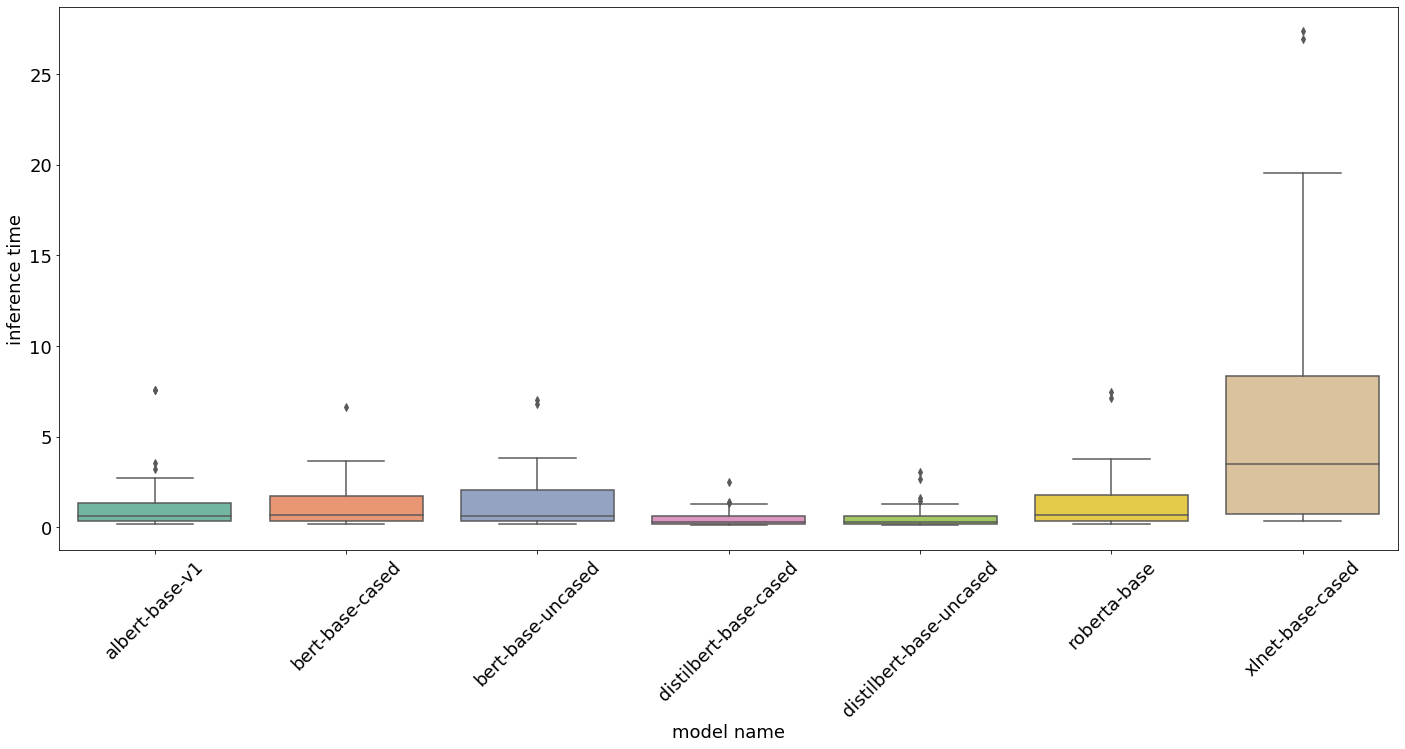

In [46]:
# Boxplots for inference time, gouped by model 

plt.figure(figsize = (24, 10))
ax = sns.boxplot(x = 'model_name_or_path', y = 'inference_time', data = data3, palette = sns.color_palette("Set2"))
plt.ylabel('inference time', fontsize = 18)
plt.xlabel('model name', fontsize = 18)
#plt.title('Boxplot of inference time by model', fontsize = 20)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=18)
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=18)
plt.show()
ax.figure.savefig('inference_time_models.png', bbox_inches='tight')

In [47]:
data3.groupby('model_name_or_path').inference_time.describe()

,count,mean,std,min,25%,50%,75%,max
model_name_or_path,,,,,,,,
albert-base-v1,45.0,1.238403,1.616211,0.181698,0.324292,0.633099,1.306758,7.570084
bert-base-cased,21.0,1.387433,1.529192,0.181052,0.355859,0.658360,1.725559,6.643081
bert-base-uncased,45.0,1.342396,1.548354,0.183177,0.322229,0.631088,2.024850,7.026921
distilbert-base-cased,21.0,0.565178,0.585868,0.091526,0.156856,0.296615,0.601720,2.465271
distilbert-base-uncased,45.0,0.560836,0.636458,0.092450,0.150897,0.287185,0.615949,3.061763
roberta-base,45.0,1.351498,1.610308,0.183351,0.332005,0.648036,1.787511,7.433448
xlnet-base-cased,45.0,6.310365,7.164285,0.330621,0.709893,3.473941,8.346511,27.374284


In [48]:
# for a fair comparison of models (especially considering cased versions)
data3[(data3.task_name == 'CoLA') | (data3.task_name == 'RTE')].groupby('model_name_or_path').inference_time.describe()

,count,mean,std,min,25%,50%,75%,max
model_name_or_path,,,,,,,,
albert-base-v1,18.0,1.306124,1.779709,0.181698,0.338028,0.594692,1.309498,7.570084
bert-base-cased,18.0,1.365648,1.626966,0.181052,0.341144,0.622629,1.631149,6.643081
bert-base-uncased,18.0,1.416056,1.649596,0.183177,0.318332,0.617871,1.997976,6.800269
distilbert-base-cased,18.0,0.540077,0.609357,0.091526,0.151996,0.279043,0.566033,2.465271
distilbert-base-uncased,18.0,0.616478,0.739974,0.092450,0.150550,0.318891,0.683456,3.061763
roberta-base,18.0,1.398953,1.762230,0.183351,0.345957,0.602934,1.736749,7.149380
xlnet-base-cased,18.0,6.335933,7.465759,0.330621,0.706303,3.405902,7.861376,26.955771


In [49]:
# Overview over inference time, grouped by every regarded hyperparameter

table = data3.groupby(['model_name_or_path', 'num_examples', 'max_seq_length', 
                       'per_device_eval_batch_size']).inference_time.median()
table.to_excel("inference_time_table.xlsx")

#### ANOVA #####

In [50]:
#!pip install statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
import statsmodels.api as sm

# seq_length_log als kat. Variable für ANOVA
data3['seq_len_cat'] = data3.loc[:,'max_seq_length'].astype('category')
mod_len = ols('inference_time ~ seq_len_cat', data=data3).fit()
# seq_length_log als kat. Variable für ANOVA
data3['batch_size_cat'] = data3.loc[:,'per_device_eval_batch_size'].astype('category')
mod_bs = ols('inference_time ~ batch_size_cat', data=data3).fit()
mod_type = ols('inference_time ~ model_name_or_path', data=data3).fit()
mod_task = ols('inference_time ~ task_name', data=data3).fit()

models = [mod_len, mod_bs, mod_type, mod_task]
model_names = ['maximum sequence length', 'batch size', 'model', 'task']

counter = 0
for m in models:
    print('ANOVA for inference time grouped by {}'.format(model_names[counter]))
    aov_table = sm.stats.anova_lm(m, typ=2)
    print(aov_table)
    print('\n')
    counter += 1

ANOVA for inference time grouped by maximum sequence length
                  sum_sq     df          F        PR(>F)
seq_len_cat   658.221090    2.0  28.479173  6.316748e-12
Residual     3050.832437  264.0        NaN           NaN


ANOVA for inference time grouped by batch size
                     sum_sq     df          F    PR(>F)
batch_size_cat   282.980092    2.0  10.902677  0.000028
Residual        3426.073435  264.0        NaN       NaN


ANOVA for inference time grouped by model
                         sum_sq     df          F        PR(>F)
model_name_or_path  1044.694048    6.0  16.990979  1.499803e-16
Residual            2664.359478  260.0        NaN           NaN


ANOVA for inference time grouped by task
                sum_sq     df         F    PR(>F)
task_name    44.057010    4.0  0.787377  0.534245
Residual   3664.996517  262.0       NaN       NaN




<ipython-input-50-6357f537f611>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['seq_len_cat'] = data3.loc[:,'max_seq_length'].astype('category')
<ipython-input-50-6357f537f611>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['batch_size_cat'] = data3.loc[:,'per_device_eval_batch_size'].astype('category')


#### Test ANOVA assumptions (not necessarily needed for my analysis because the ANOVA is just an ad-on)

In [51]:
# Shapiro-Wilk test: check normal distribution of residuals; H0: data is drawn from normal distribution

counter = 0
for m in models:
    w, pvalue = stats.shapiro(m.resid)
    print('p-value of the Shapiro-Wilk test for fine-tuning time and {}: '.format(model_names[counter]) , pvalue)
    counter += 1

# As the P-value is significant for all models, H0 is rejected. One cannot assume normality

p-value of the Shapiro-Wilk test for fine-tuning time and maximum sequence length:  1.0536687315570409e-23
p-value of the Shapiro-Wilk test for fine-tuning time and batch size:  1.2996891402515588e-25
p-value of the Shapiro-Wilk test for fine-tuning time and model:  2.91455629755929e-22
p-value of the Shapiro-Wilk test for fine-tuning time and task:  3.38322597467145e-26


ANOVA for inference time grouped by maximum sequence length


<Figure size 720x720 with 0 Axes>

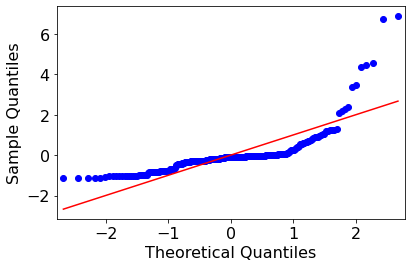



ANOVA for inference time grouped by batch size


<Figure size 720x720 with 0 Axes>

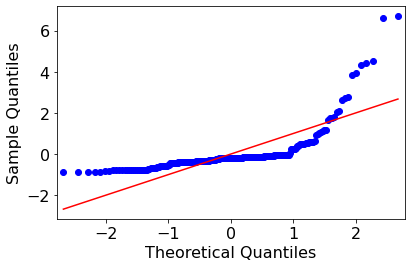



ANOVA for inference time grouped by model


<Figure size 720x720 with 0 Axes>

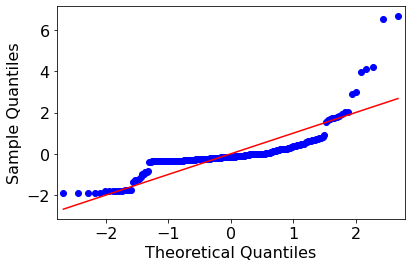



ANOVA for inference time grouped by task


<Figure size 720x720 with 0 Axes>

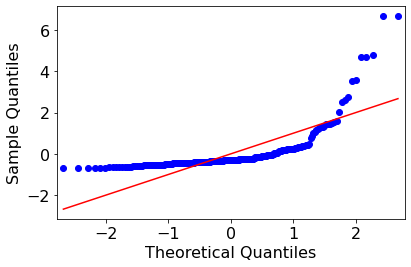

In [52]:
# Q-Q plot for ANOVAs to check normality assumption 
counter = 0
for m in models:
    res = m.resid
    plt.figure(figsize = (10, 10))
    fig = sm.qqplot(res, line='s', fit = True)
    plt.xlabel('Theoretical Quantiles', fontsize = 16)
    plt.ylabel('Sample Quantiles', fontsize = 16)
    plt.tight_layout()
    print('ANOVA for inference time grouped by {}'.format(model_names[counter]))
    plt.show()
    fig.savefig('inference_time_qqplot_anova_{}.png'.format(model_names[counter]))
    counter += 1
    print('\n')
    
# The data seems not to be samples from a normal distribution

In [53]:
# Levene’s test to check the Homogeneity of variances (for non-normal data). H0: samples from populations have equal variances.

from scipy.stats import levene

stats_seq_len, p_seq_len = levene(data3.inference_time.loc[data3.max_seq_length==128], 
                                  data3.inference_time.loc[data3.max_seq_length==256], 
                                  data3.inference_time.loc[data3.max_seq_length==512])
print('p-value of the Levene’s test for maximum sequence length: ', p_seq_len)

stats_bs, p_bs = levene(data3.inference_time.loc[data3.per_device_eval_batch_size==8], 
                        data3.inference_time.loc[data3.per_device_eval_batch_size==16], 
                        data3.inference_time.loc[data3.per_device_eval_batch_size==32])
print('p-value of the Levene’s test for batch size: ', p_bs)

LM_names = []
for name in np.unique(data3.model_name_or_path):
    LM_names.append(name)
    
stats_model, p_model = levene(data3.inference_time.loc[data3.model_name_or_path == LM_names[0]], 
                        data3.inference_time.loc[data3.model_name_or_path == LM_names[1]], 
                        data3.inference_time.loc[data3.model_name_or_path == LM_names[2]], 
                        data3.inference_time.loc[data3.model_name_or_path == LM_names[3]], 
                        data3.inference_time.loc[data3.model_name_or_path == LM_names[4]], 
                        data3.inference_time.loc[data3.model_name_or_path == LM_names[5]], 
                        data3.inference_time.loc[data3.model_name_or_path == LM_names[6]])
print('p-value of the Levene’s test for model: ', p_model)

task_names = []
for name in np.unique(data3.task_name):
    task_names.append(name)
    
stats_task, p_task = levene(data3.inference_time.loc[data3.task_name == task_names[0]], 
                        data3.inference_time.loc[data3.task_name == task_names[1]], 
                        data3.inference_time.loc[data3.task_name == task_names[2]], 
                        data3.inference_time.loc[data3.task_name == task_names[3]], 
                        data3.inference_time.loc[data3.task_name == task_names[4]])
print('p-value of the Levene’s test for task: ', p_task)

# As the p-values are all significant, H0 is rejected. Hence, one cannot assume homogeneity of variances 
    # for any of the conducted ANOVAs

p-value of the Levene’s test for maximum sequence length:  4.3893037776109155e-09
p-value of the Levene’s test for batch size:  0.0007646774090128281
p-value of the Levene’s test for model:  2.790084799628301e-16
p-value of the Levene’s test for task:  0.5398139631899825


In [54]:
## Tukey's range test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# maximum sequence length
res_sq_len = pairwise_tukeyhsd(data3['inference_time'], data3['seq_len_cat'])
print('Pairwise Tukeys range test w.r.t. maximum sequence length')
print(res_sq_len)

# batch size
res_bs = pairwise_tukeyhsd(data3['inference_time'], data3['batch_size_cat'])
print('Pairwise Tukeys range test w.r.t. batch size')
print(res_bs)

# model 
res_model = pairwise_tukeyhsd(data3['inference_time'], data3['model_name_or_path'])
print('Pairwise Tukeys range test w.r.t. model')
print(res_model)

# task
res_task = pairwise_tukeyhsd(data3['inference_time'], data3['task_name'])
print('Pairwise Tukeys range test w.r.t. task')
print(res_task)

Pairwise Tukeys range test w.r.t. maximum sequence length
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   128    256   0.7842 0.283 -0.4308 1.9991  False
   128    512     3.62 0.001  2.4248 4.8151   True
   256    512   2.8358 0.001  1.6406  4.031   True
--------------------------------------------------
Pairwise Tukeys range test w.r.t. batch size
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     8     16   0.8753 0.2388 -0.3976 2.1483  False
     8     32   2.4858  0.001  1.2128 3.7587   True
    16     32   1.6104 0.0088  0.3375 2.8833   True
---------------------------------------------------
Pairwise Tukeys range test w.r.t. model
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
         group1                  group2         me

#### Linear regression model ####
Reference categories: 
- task: RTE
- model: bert-base-uncased

In [55]:
from statsmodels.regression import linear_model
import patsy
from patsy.contrasts import Treatment

In [56]:
# linear regression model (w/o transformation of variables)

y, X = patsy.dmatrices('inference_time ~ C(model_name_or_path, Treatment(reference="bert-base-uncased")) + C(task_name, Treatment(reference="RTE")) + per_device_eval_batch_size + max_seq_length', 
                       data3)

# linear regression model
model = linear_model.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         inference_time   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     26.17
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           6.77e-38
Time:                        21:37:07   Log-Likelihood:                -622.70
No. Observations:                 267   AIC:                             1271.
Df Residuals:                     254   BIC:                             1318.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================================================
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                     -3.0734      0.634     -4.849      0.000      -4.322      -1.825
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.albert-base-v1]             -0.1040      0.539     -0.193      0.847      -1.165       0.957
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.bert-base-cased]            -0.3116      0.695     -0.448      0.654      -1.681       1.058
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-cased]      -1.1339      0.695     -1.631      0.104      -2.503       0.235
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-uncased]    -0.7816      0.539     -1.451      0.148      -1.843       0.279
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.roberta-base]                0.0091      0.539      0.017      0.987      -1.052       1.070
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.xlnet-base-cased]            4.9680      0.539      9.222      0.000       3.907       6.029
C(task_name, Treatment(reference="RTE"))[T.CoLA]                                              -0.7267      0.455     -1.596      0.112      -1.623       0.170
C(task_name, Treatment(reference="RTE"))[T.MRPC]                                              -0.9370      0.488     -1.918      0.056      -1.899       0.025
C(task_name, Treatment(reference="RTE"))[T.STS-B]                                             -0.8481      0.516     -1.644      0.101      -1.864       0.168
C(task_name, Treatment(reference="RTE"))[T.WNLI]                                               0.0262      0.516      0.051      0.960      -0.990       1.042
per_device_eval_batch_size                                                                     0.1032      0.016      6.581      0.000       0.072       0.134
max_seq_length                                                                                 0.0100      0.001     10.245      0.000       0.008       0.012
==============================================================================
Omnibus:                      204.969   Durbin-Watson:                   0.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3319.277
Skew:                           2.934   Prob(JB):                         0.00
Kurtosis:                      19.246   Cond. No.                     2.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix 

In [57]:
# distribution of inference time is right skewed --> Take the log of the inference time
data3['inference_time_log'] = data3.inference_time.apply(lambda x: math.log(x))
data3.inference_time_log.describe()

<ipython-input-57-71880d56844f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['inference_time_log'] = data3.inference_time.apply(lambda x: math.log(x))


count    267.000000
mean      -0.206390
std        1.239700
min       -2.391132
25%       -1.141165
50%       -0.465199
75%        0.641127
max        3.309604
Name: inference_time_log, dtype: float64

In [58]:
# log-linear regression model with logarithmized inference time

y, X = patsy.dmatrices('inference_time_log ~ C(model_name_or_path, Treatment(reference="bert-base-uncased")) + C(task_name, Treatment(reference="RTE")) + per_device_eval_batch_size + max_seq_length', 
                       data3)

# linear regression model
model = linear_model.OLS(y, X).fit()
model.summary()

# Jarque-Bera Test: JB = 1.976 < 6 --> H0 (residuals follow a normal distribution) is not rejected to a singificance level of 0.05
# Durbin-Watson test: d = 1.143: not within the range of 1.5 and 2.5, but higher than 1) 
    # --> not clear if autocorrelation could be problematic

# R^2 of log-linear regression model is higher (0.92) than the one of the linear regression model (0.553)
# --> Use log-linear regression model 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     inference_time_log   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     242.4
Date:                Mon, 16 Nov 2020   Prob (F-statistic):          1.62e-131
Time:                        21:37:09   Log-Likelihood:                -99.039
No. Observations:                 267   AIC:                             224.1
Df Residuals:                     254   BIC:                             270.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================================================
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                     -2.6125      0.089    -29.299      0.000      -2.788      -2.437
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.albert-base-v1]             -0.0795      0.076     -1.048      0.295      -0.229       0.070
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.bert-base-cased]            -0.0824      0.098     -0.843      0.400      -0.275       0.110
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-cased]      -0.9253      0.098     -9.460      0.000      -1.118      -0.733
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-uncased]    -0.8215      0.076    -10.839      0.000      -0.971      -0.672
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.roberta-base]                0.0037      0.076      0.049      0.961      -0.146       0.153
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.xlnet-base-cased]            1.2977      0.076     17.123      0.000       1.148       1.447
C(task_name, Treatment(reference="RTE"))[T.CoLA]                                              -0.2377      0.064     -3.711      0.000      -0.364      -0.112
C(task_name, Treatment(reference="RTE"))[T.MRPC]                                              -0.2899      0.069     -4.219      0.000      -0.425      -0.155
C(task_name, Treatment(reference="RTE"))[T.STS-B]                                             -0.2560      0.073     -3.528      0.000      -0.399      -0.113
C(task_name, Treatment(reference="RTE"))[T.WNLI]                                               0.0104      0.073      0.144      0.886      -0.132       0.153
per_device_eval_batch_size                                                                     0.0585      0.002     26.550      0.000       0.054       0.063
max_seq_length                                                                                 0.0049      0.000     35.461      0.000       0.005       0.005
==============================================================================
Omnibus:                        1.891   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.976
Skew:                           0.190   Prob(JB):                        0.372
Kurtosis:                       2.817   Cond. No.                     2.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix 

<Figure size 720x720 with 0 Axes>

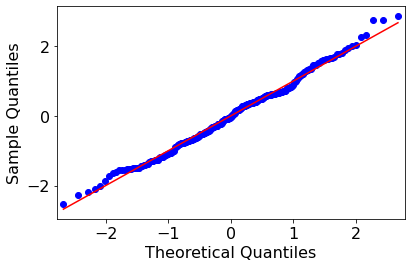

In [59]:
# residuals (QQ Plot) to check for normality

res = model.resid
plt.figure(figsize = (10, 10))
fig = sm.qqplot(res, line='s', fit = True)
plt.xlabel('Theoretical Quantiles', fontsize = 16)
plt.ylabel('Sample Quantiles', fontsize = 16)
plt.tight_layout()
plt.show()
fig.savefig('inference_time_linreg_qqplot.png')

# we can assume normality of residuals

Scatterplot log. inference time and batch size


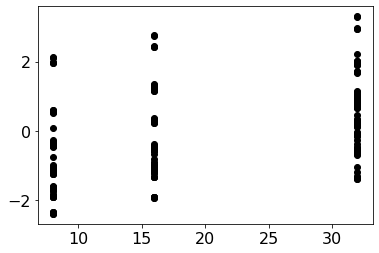

Scatterplot log. inference time and maximum sequence length


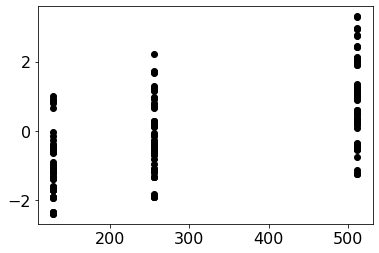

In [65]:
# Check linearity assumption (makes little sense since hyperparameters incorporate only three values)

print('Scatterplot log. inference time and batch size')
plt.plot(data3.per_device_eval_batch_size, data3.inference_time_log, 'o', color='black')
plt.show()

print('Scatterplot log. inference time and maximum sequence length')
plt.plot(data3.max_seq_length, data3.inference_time_log, 'o', color='black')
plt.show()

In [60]:
# Breusch-Pagan test to check homoscedasticity of residuals

from statsmodels.compat import lzip
import statsmodels.stats.api as sms

name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)
lzip(name, test)

# p-value of Lagrange multiplier statistic very low < 0.05 --> H0 (homoscedasticity) can be rejected

[('Lagrange multiplier statistic', 48.249472382753716),
 ('p-value', 2.8281428327875124e-06),
 ('f-value', 4.66869959077424),
 ('f p-value', 7.291730398881624e-07)]

In [44]:
# regression model (with logarithmized inference time and quadr. max. seq. length)

data3['seq_len_quadr'] = data3.max_seq_length.apply(lambda x: x**2)

y, X = patsy.dmatrices('inference_time_log ~ C(model_name_or_path, Treatment(reference="bert-base-uncased")) + C(task_name, Treatment(reference="RTE")) + per_device_eval_batch_size + seq_len_quadr', 
                       data3)

# regression model
model = linear_model.OLS(y, X).fit()
model.summary()

## R^2 is worse (0.9) than the one of log-linear regression model (0.92) --> stick with log-linear regression model

<ipython-input-44-07f716014b23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['seq_len_quadr'] = data3.max_seq_length.apply(lambda x: x**2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     inference_time_log   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     191.2
Date:                Thu, 05 Nov 2020   Prob (F-statistic):          1.17e-119
Time:                        16:27:34   Log-Likelihood:                -127.86
No. Observations:                 267   AIC:                             281.7
Df Residuals:                     254   BIC:                             328.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================================================
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                     -1.9754      0.092    -21.387      0.000      -2.157      -1.794
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.albert-base-v1]             -0.0795      0.084     -0.941      0.347      -0.246       0.087
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.bert-base-cased]            -0.0846      0.109     -0.776      0.438      -0.299       0.130
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-cased]      -0.9275      0.109     -8.511      0.000      -1.142      -0.713
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-uncased]    -0.8215      0.084     -9.730      0.000      -0.988      -0.655
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.roberta-base]                0.0037      0.084      0.044      0.965      -0.163       0.170
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.xlnet-base-cased]            1.2977      0.084     15.371      0.000       1.131       1.464
C(task_name, Treatment(reference="RTE"))[T.CoLA]                                              -0.2377      0.071     -3.331      0.001      -0.378      -0.097
C(task_name, Treatment(reference="RTE"))[T.MRPC]                                              -0.2918      0.077     -3.812      0.000      -0.443      -0.141
C(task_name, Treatment(reference="RTE"))[T.STS-B]                                             -0.2567      0.081     -3.175      0.002      -0.416      -0.097
C(task_name, Treatment(reference="RTE"))[T.WNLI]                                               0.0098      0.081      0.121      0.904      -0.149       0.169
per_device_eval_batch_size                                                                     0.0585      0.002     23.833      0.000       0.054       0.063
seq_len_quadr                                                                               7.134e-06    2.3e-07     31.049      0.000    6.68e-06    7.59e-06
==============================================================================
Omnibus:                        3.522   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                3.395
Skew:                           0.276   Prob(JB):                        0.183
Kurtosis:                       3.013   Cond. No.                     1.16e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix 

In [45]:
# log-linear regression model with logarithmic inference time and interaction between maximum sequence length and batch size

y, X = patsy.dmatrices('inference_time_log ~ C(model_name_or_path, Treatment(reference="bert-base-uncased")) + C(task_name, Treatment(reference="RTE")) + per_device_eval_batch_size + max_seq_length + per_device_eval_batch_size:max_seq_length', 
                       data3)

# log-linear regression model
model = linear_model.OLS(y, X).fit()
model.summary()

# R^2 is exactly the same as than the one of log-linear regression model. Since the other model is more comprehensive 
# --> stick with log-linear regression model (w/o interaction)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     inference_time_log   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     222.9
Date:                Thu, 05 Nov 2020   Prob (F-statistic):          2.57e-130
Time:                        16:27:40   Log-Likelihood:                -99.039
No. Observations:                 267   AIC:                             226.1
Df Residuals:                     253   BIC:                             276.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================================================
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                     -2.6098      0.118    -22.036      0.000      -2.843      -2.377
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.albert-base-v1]             -0.0795      0.076     -1.046      0.296      -0.229       0.070
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.bert-base-cased]            -0.0824      0.098     -0.841      0.401      -0.275       0.111
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-cased]      -0.9253      0.098     -9.441      0.000      -1.118      -0.732
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.distilbert-base-uncased]    -0.8215      0.076    -10.818      0.000      -0.971      -0.672
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.roberta-base]                0.0037      0.076      0.048      0.961      -0.146       0.153
C(model_name_or_path, Treatment(reference="bert-base-uncased"))[T.xlnet-base-cased]            1.2977      0.076     17.089      0.000       1.148       1.447
C(task_name, Treatment(reference="RTE"))[T.CoLA]                                              -0.2377      0.064     -3.703      0.000      -0.364      -0.111
C(task_name, Treatment(reference="RTE"))[T.MRPC]                                              -0.2899      0.069     -4.211      0.000      -0.426      -0.154
C(task_name, Treatment(reference="RTE"))[T.STS-B]                                             -0.2560      0.073     -3.522      0.001      -0.399      -0.113
C(task_name, Treatment(reference="RTE"))[T.WNLI]                                               0.0104      0.073      0.143      0.886      -0.133       0.154
per_device_eval_batch_size                                                                     0.0584      0.005     12.387      0.000       0.049       0.068
max_seq_length                                                                                 0.0049      0.000     16.717      0.000       0.004       0.005
per_device_eval_batch_size:max_seq_length                                                   4.732e-07   1.37e-05      0.034      0.973   -2.66e-05    2.75e-05
==============================================================================
Omnibus:                        1.885   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.390   Jarque-Bera (JB):                1.969
Skew:                           0.190   Prob(JB):                        0.374
Kurtosis:                       2.820   Cond. No.               

#### Random Forest

In [47]:
# Encode model names 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(np.unique(data3.model_name_or_path))
LabelEncoder()
list(le.classes_)
data3['model_encoded'] = le.transform(data3.model_name_or_path)

# print unique values of encoded model variable
np.unique(data3.model_encoded)

<ipython-input-47-30a4e8f3ad0a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['model_encoded'] = le.transform(data3.model_name_or_path)


array([0, 1, 2, 3, 4, 5, 6])

In [49]:
# Encode task names

lenc = LabelEncoder()
lenc.fit(np.unique(data3.task_name))
LabelEncoder()
list(lenc.classes_)
data3['task_encoded'] = lenc.transform(data3.task_name)

# print unique values of encoded model variable
np.unique(data3.task_encoded)

<ipython-input-49-712906d2410e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['task_encoded'] = lenc.transform(data3.task_name)


array([0, 1, 2, 3, 4])

In [51]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

X = data3[['task_encoded', 'max_seq_length', 'per_device_eval_batch_size', 'model_encoded']]
y = data3[['inference_time_log']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators = 500)
regr.fit(X_train, np.ravel(y_train))
y_pred = regr.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.33592045661049935
Mean Squared Error: 0.17971684175188557
Root Mean Squared Error: 0.4239302321749247


In [52]:
importances = regr.feature_importances_
print(importances)

[0.01663667 0.50462102 0.23102093 0.24772138]


Feature: 0, Score: 0.01664
Feature: 1, Score: 0.50462
Feature: 2, Score: 0.23102
Feature: 3, Score: 0.24772


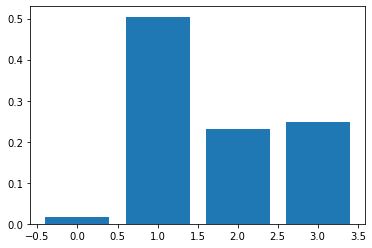

In [53]:
for i,v in enumerate(importances):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()

# task_encoded, max_seq_length, per_device_eval_batch_size, model_encoded

#### Relation between inference time and performance measures

In [56]:
np.unique(data.columns)

array(['Agent', 'Created', 'Notes', 'Runtime', 'State', 'Sweep', 'Tags',
       'Training time', 'User', '__cached__setup_devices', 'adam_epsilon',
       'data_dir', 'dataloader_drop_last', 'debug', 'do_eval',
       'do_predict', 'do_train', 'epoch', 'eval_acc', 'eval_acc_and_f1',
       'eval_corr', 'eval_f1', 'eval_loss', 'eval_mcc', 'eval_pearson',
       'eval_spearmanr', 'eval_steps', 'evaluate_during_training',
       'finetuning_iters', 'finetuning_time', 'finetuning_time_list',
       'fp16', 'fp16_opt_level', 'gradient_accumulation_steps',
       'inference_time', 'inference_time_list', 'learning_rate',
       'local_rank', 'logging_dir', 'logging_first_step', 'logging_steps',
       'loss', 'max_grad_norm', 'max_seq_length', 'max_steps',
       'model_name_or_path', 'no_cuda', 'num_train_epochs', 'output_dir',
       'overwrite_output_dir', 'past_index', 'per_device_eval_batch_size',
       'per_device_train_batch_size', 'per_gpu_train_batch_size',
       'save_steps', 'see

In [37]:
data3[['eval_acc', 'eval_corr', 'eval_f1', 'eval_mcc',
       'eval_pearson', 'eval_spearmanr', 'task_name']].groupby("task_name").count()

# the majority of tasks incorporates the accuracy as performance measure 
# --> analysis of the relation between inference time and the accuracy is the main focus

,eval_acc,eval_corr,eval_f1,eval_mcc,eval_pearson,eval_spearmanr
task_name,,,,,,
CoLA,0,0,0,63,0,0
MRPC,51,0,51,0,0,0
RTE,63,0,0,0,0,0
STS-B,0,45,0,0,45,45
WNLI,45,0,0,0,0,0


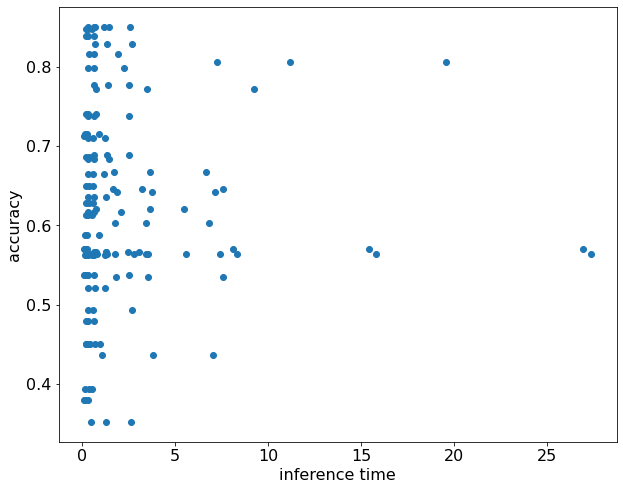

In [85]:
plt.figure(figsize = (10, 8))
scatter = plt.scatter(data3.inference_time, data3.eval_acc)
plt.ylabel('accuracy', fontsize = 16)
plt.xlabel('inference time', fontsize = 16)
#plt.title('Scatterplot inference time and accuracy', fontsize = 18)
plt.show()
scatter.figure.savefig('scatter_inference_accuracy.png')

In [34]:
# delete all missing values of the accuracy to enable calculating the correlation

data4 = data3.dropna(subset=['eval_acc', 'inference_time'])
data4.shape[0]

159

#### Further analyses

In [35]:
np.corrcoef(data4.inference_time, data4.eval_acc)

array([[ 1.0000000e+00, -9.9917988e-04],
       [-9.9917988e-04,  1.0000000e+00]])

In [88]:
data5 = data3.dropna(subset=['eval_f1', 'inference_time'])
data5.shape[0]

51

In [90]:
np.corrcoef(data5.inference_time, data5.eval_f1.astype('float64'))

array([[1.        , 0.11087352],
       [0.11087352, 1.        ]])

In [91]:
data6 = data3.dropna(subset=['eval_mcc', 'inference_time'])
data6.shape[0]

63

In [92]:
np.corrcoef(data6.inference_time, data6.eval_mcc.astype('float64'))

array([[ 1.        , -0.23556001],
       [-0.23556001,  1.        ]])

In [93]:
data7 = data3.dropna(subset=['eval_corr', 'inference_time'])
data7.shape[0]

45

In [94]:
np.corrcoef(data7.inference_time, data7.eval_corr.astype('float64'))

array([[ 1.        , -0.35353102],
       [-0.35353102,  1.        ]])

In [95]:
data8 = data3.dropna(subset=['eval_pearson', 'inference_time'])
data8.shape[0]

45

In [96]:
np.corrcoef(data8.inference_time, data8.eval_pearson.astype('float64'))

array([[ 1.        , -0.35737557],
       [-0.35737557,  1.        ]])

In [97]:
data9 = data3.dropna(subset=['eval_spearmanr', 'inference_time'])
data9.shape[0]

45

In [98]:
np.corrcoef(data9.inference_time, data9.eval_spearmanr.astype('float64'))

array([[ 1.       , -0.3474667],
       [-0.3474667,  1.       ]])

In [99]:
data10 = data3.dropna(subset=['eval_loss', 'inference_time'])
data10.shape[0]

267

In [100]:
np.corrcoef(data10.inference_time, data10.eval_loss.astype('float64'))

array([[1.        , 0.12884787],
       [0.12884787, 1.        ]])